In [1]:
import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CHAR_SET_LEN = 10

IMAGE_HEIGHT = 60

IMAGE_WIDTH = 160

BATCH_SIZE = 1

TFRECORD_FILE = "./captcha-tfrecords/test.tfrecords"

x = tf.placeholder(tf.float32, [None, 224, 224])

In [3]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'image': tf.FixedLenFeature([], tf.string),
                                           'label0': tf.FixedLenFeature([], tf.int64),
                                           'label1': tf.FixedLenFeature([], tf.int64),
                                           'label2': tf.FixedLenFeature([], tf.int64),
                                           'label3': tf.FixedLenFeature([], tf.int64)
                                       })
    # get image data
    image = tf.decode_raw(features['image'], tf.uint8)
    image_raw= tf.reshape(image, [224, 224])
    image = tf.reshape(image, [224, 224])
    
    # preprocess image
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    
    # get labels
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)

    return image, image_raw, label0, label1, label2, label3

In [4]:
image, image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
    [image, image_raw, label0, label1, label2, label3], batch_size=BATCH_SIZE,
    capacity=50000, min_after_dequeue=10000, num_threads=1)

train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes=CHAR_SET_LEN,
    weight_decay=0.0005,
    is_training=False)

INFO:tensorflow:Restoring parameters from ./captcha-models/crack_captcha.model-2140


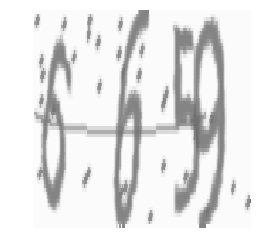

Label:      [6][6][5][9]
Prediction: [6][6][5][9]


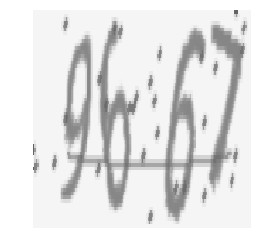

Label:      [9][6][6][7]
Prediction: [9][6][6][7]


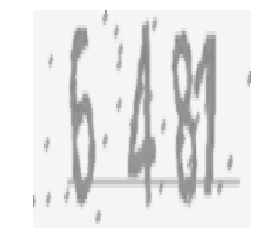

Label:      [6][4][8][1]
Prediction: [6][4][8][1]


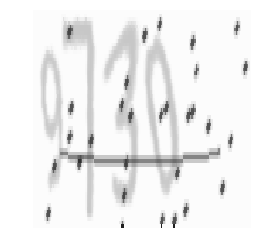

Label:      [9][7][3][0]
Prediction: [9][7][3][8]


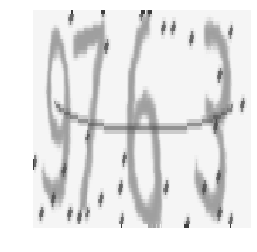

Label:      [9][7][6][3]
Prediction: [9][7][6][3]


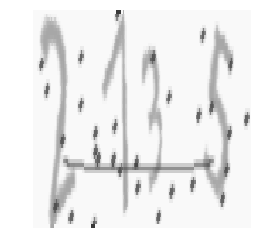

Label:      [2][7][3][5]
Prediction: [2][2][3][5]


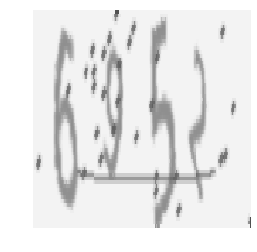

Label:      [6][9][5][2]
Prediction: [6][9][5][2]


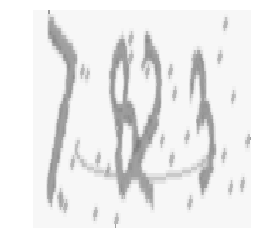

Label:      [7][8][2][3]
Prediction: [7][8][2][3]


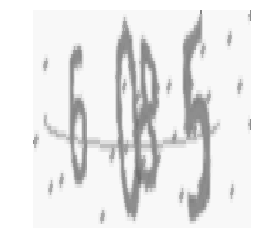

Label:      [6][0][8][5]
Prediction: [6][0][8][5]


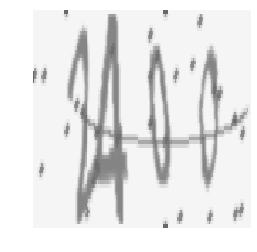

Label:      [2][4][0][0]
Prediction: [2][4][0][0]


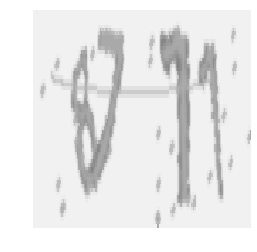

Label:      [8][7][1][1]
Prediction: [8][7][1][1]


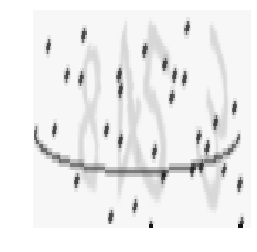

Label:      [8][4][5][3]
Prediction: [6][7][5][7]


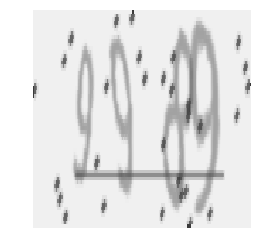

Label:      [9][9][8][9]
Prediction: [9][9][8][9]


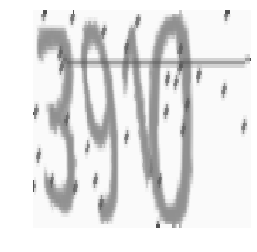

Label:      [3][9][1][0]
Prediction: [3][9][1][0]


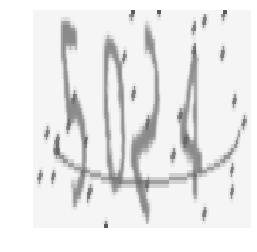

Label:      [5][0][2][4]
Prediction: [5][0][2][4]


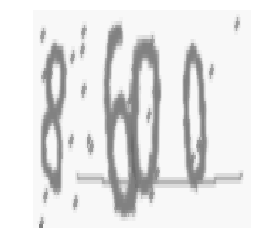

Label:      [8][6][0][0]
Prediction: [8][6][0][0]


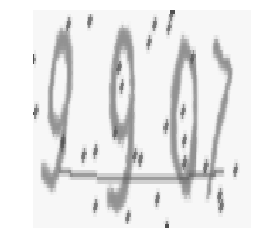

Label:      [9][9][0][7]
Prediction: [9][9][0][7]


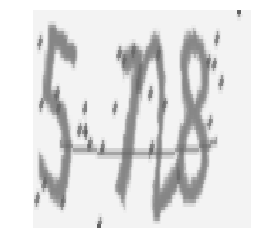

Label:      [5][1][2][8]
Prediction: [5][1][2][8]


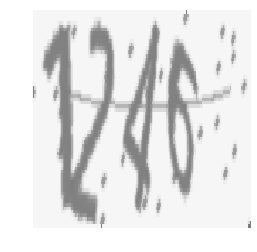

Label:      [1][2][4][6]
Prediction: [1][2][4][6]


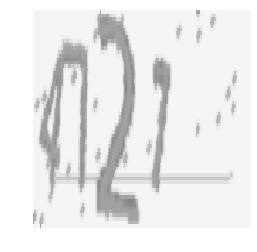

Label:      [4][7][2][1]
Prediction: [4][2][7][1]


In [5]:
if __name__ == "__main__":
    image, image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

    image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
        [image, image_raw, label0, label1, label2, label3], batch_size=BATCH_SIZE,
        capacity=50000, min_after_dequeue=10000, num_threads=1)

    train_network_fn = nets_factory.get_network_fn(
        'alexnet_v2',
        num_classes=CHAR_SET_LEN,
        weight_decay=0.0005,
        is_training=False)
    
    with tf.Session() as sess:
        # inputs: a tensor of size [batch_size, height, width, channels]
        X = tf.reshape(x, [BATCH_SIZE, 224, 224, 1])
        
        # get results
        logits0, logits1, logits2, logits3, end_points = train_network_fn(X)

        # get predictions
        predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])
        predict0 = tf.argmax(predict0, 1)

        predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])
        predict1 = tf.argmax(predict1, 1)

        predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])
        predict2 = tf.argmax(predict2, 1)

        predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])
        predict3 = tf.argmax(predict3, 1)

        sess.run(tf.global_variables_initializer())
        
        # load model
        saver = tf.train.Saver()
        saver.restore(sess, './captcha-models/crack_captcha.model-2140')

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        for i in range(20):
            b_image, b_image_raw, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch,
                                                                                     image_raw_batch,
                                                                                     label_batch0,
                                                                                     label_batch1,
                                                                                     label_batch2,
                                                                                     label_batch3])

            # display image
            img = Image.fromarray(b_image_raw[0], 'L')

            plt.imshow(img)
            plt.axis('off')
            plt.show()

            print("Label:      {}{}{}{}".format(b_label0, b_label1, b_label2, b_label3))

            # predictions
            label0, label1, label2, label3 = sess.run([predict0, predict1, predict2, predict3],
                                                      feed_dict={x: b_image})

            print("Prediction: {}{}{}{}".format(label0, label1, label2, label3))

        coord.request_stop()
        coord.join(threads)